### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2023 Semester 2

## Assignment 1

**Student Name:**    `Tanzid Sultan`

**Student ID:**     `1430660`

This iPython notebook is a template which you should use for your Assignment 1 submission. This file should be submitted at the **Assignment 1** link on the LMS, along with any images needed to run your code.

In addition to this file, you should submit a written report explaining your results at the **Assignment 1** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

### 0. Laplacian pyramid compression
You can use the code below to check how much a quantized Laplacian pyramid representation compresses an image.

In [16]:
imSize = 256 # image height/width (assume image is square)
bitsPerLevel = [2,3,4,5,6,7,8] # bits used to encode each level of pyramid

# Image size before compression, in bits (assume uint8 grayscale)
sizeUncompressed = 8 * imSize * imSize
print('Uncompressed size = '+str(sizeUncompressed)+' bits')

# Image size after compression, in bits
sizeCompressed = 0
for i in range(len(bitsPerLevel)):
    sizeCompressed = sizeCompressed + (bitsPerLevel[i]*(imSize/(pow(2,i)))*(imSize/(pow(2,i))))
print('Compressed size = '+str(sizeCompressed)+' bits')

print(str(round(100*sizeCompressed/sizeUncompressed))+'% of original')

Uncompressed size = 524288 bits
Compressed size = 203840.0 bits
39% of original


### 1. Laplacian image pyramid

In [17]:
import numpy as np

# Define the filter kernel
kernel = (1/256)*np.array([[1, 4, 6, 4, 1],
                           [4, 16, 24, 16, 4],
                           [6, 24, 36, 24, 6],
                           [4, 16, 24, 16, 4],
                           [1, 4, 6, 4, 1]])


In [18]:
import cv2
import os
from matplotlib import pyplot as plt

#### The test image is expected to be in the same directory as this Jupyter notebook 

In [19]:
# read in test image from root path as 8-bit grayscale
rootpath='./'
test_img = cv2.imread(os.path.join(rootpath, "test_image.jpg"),cv2.IMREAD_GRAYSCALE)
print(f"Test image dimensions: {test_img.shape}")

Test image dimensions: (1024, 1024)


#### Functions for computing the laplacian pyramid of an image and image reconstruction are implemented below (along with several other helper functions)

In [20]:
'''
    helper function for 2d convolution of an image with a given kernel/filter
    
    Parameters:
    I - 2d image array
    kernel - 2d filter array
'''
def filter(I, kernel):
    
    return cv2.filter2D(I, -1, kernel)


'''
    helper function for downsampling an image by a factor of 1/2
   
    Parameters:
    I - 2d image array
    '''
def downsample(I):
    # keep every other row/column
    D = I[1::2, 1::2]

    return D


'''
    helper function for upsampling an image by factor of 2

    Parameters:
    I - 2d image array
'''
def upsample(I):
    height = I.shape[0] 
    width =  I.shape[1]
    U = np.zeros(shape=(2*height, 2*width))
    # upsampled image will contain zeros on every other row/column
    U[::2,::2] = I

    return U        


'''
    function for creating a laplace pyramid for an input image

    Parameters:
    I - 2d image array
    g - 2d gaussian filter array
    n - number of pyramid levels
'''
def createLaplacePyramid(I, g, n):
    # list of pyramid images
    L_pyramid = []
    # iterate over pyramid image levels 
    for i in range(n):
        if i < (n-1):
            # filter the image with gaussian kernel
            F = filter(I, g)
            # downsample the filtered image
            D = downsample(F)
            # upsample the image then filter by the gaussian kernel and increase brightness by 
            # a factor of 4 to compensate for upsampling
            U = filter(upsample(D), 4*g)
            # compute difference image for this level
            L = I - U
            L_pyramid.append(L)
            # use downsampled image as input for next level
            I = D
        else:
            # the last level will not be processed any further
            L_pyramid.append(I)    

    return L_pyramid        


'''
    function for reconstructing image from its laplace pyramid representation

    Parameters:
    L - laplacian pyramid 
    g - 2d gaussian filter array
'''
def reconstructFromPyramid(L, g):
    n = len(L)
    # start from the highest pyramid level
    I = L[-1]
    for i in range(n-2, -1,-1):
        # upsample the pyramid image and apply filter compensated for brightness
        U = filter(upsample(I), 4*g)
        # add this to the pyramid difference image from the level below
        I = U + L[i]

    return I


In [21]:
'''
    Some functions for creating nice plots of Laplacian pyramid
'''
def plotPyramid(img, pyramid):
    plt.figure(figsize=(14,7))
    n = len(pyramid)
    plt.subplot(1,n+1,1)
    plt.imshow(img, cmap='gray')
    plt.title('original image')
    plt.axis('off')

    for i in range(n):
        plt.subplot(1,n+1,i+2)
        plt.imshow(pyramid[i], cmap='gray')
        plt.title('L'+ str(i))
        plt.axis('off')


def plotPyramidToScale(pyramid):
    n = len(pyramid)
  
    ratios = [2**i for i in range(n-1,-1, -1)]
    fig, axes = plt.subplots(
        nrows=1, ncols=n, sharex=False, sharey=False, 
        gridspec_kw={'width_ratios':ratios},
        figsize=(10,8)
        )
   
    for i in range(0,n):
        axes[i].imshow(pyramid[i], cmap='gray') 
        axes[i].axis('off')
    

def plotPyramidHistograms(img, pyramid):
    plt.figure(figsize=(18,2))
    n = len(pyramid)
    plt.subplot(1,n+1,1)
    plt.hist(np.ravel(img), bins=50)
    plt.title('original image histogram')
    for i in range(n):
        plt.subplot(1,n+1,i+2)
        plt.hist(np.ravel(pyramid[i]), bins=50, range=[-128, 128])
        plt.title('L'+ str(i))


def compareImages(img, rec_img):

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img, cmap='gray')
    plt.title('original image')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(rec_img, cmap='gray')
    plt.title('reconstructed image')
    plt.axis('off')

    mse = np.linalg.norm(img-rec_img, ord=2) / np.size(img)
    print(f"Mean squared error in reconstruction = {mse}")

#### Now we compute the Laplace Pyramid (with 5 levels)  for a test image

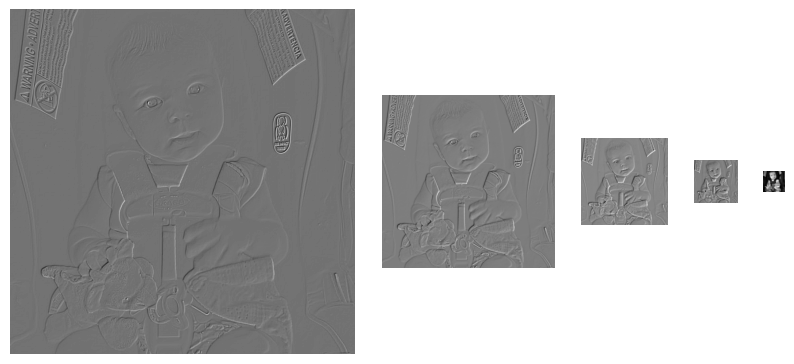

In [22]:
# compute 5 level laplace pyramid
L_pyramid = createLaplacePyramid(test_img, kernel, 5)

# diplay the pyramid images
plotPyramidToScale(L_pyramid)

#### Now we reconstruct the image from the 5 level pyramid representation

Mean squared error in reconstruction = 0.0


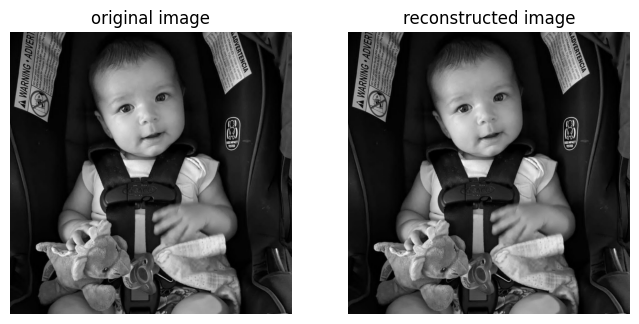

In [23]:
reconstructed_img = reconstructFromPyramid(L_pyramid, kernel)
compareImages(test_img, reconstructed_img)

#### Checking to see if the reconstruction is perfect:

In [24]:
# check if reconstructed image has identical pixel values to original image, i.,e. perfect reconstruction
print("The reconstruction is perfect: ",np.array_equal(test_img, reconstructed_img))

The reconstruction is perfect:  True


#### This is a perfect reconstruction since the two images are identical!

### 2. Quantization and compression

#### Below, we implement a function for quantizing an image into $b$ bits. The quantization procedure involves dividing the image pixels into $2^b$ *equal-frequency* bins. This is acheived by flattening the 2d image pixel array into a 1d array and sorting the values in ascending order and splitting this sorted 1d array of pixels into equal sized partitions. Each of these partitions is a bin and the left and right bin edges are just the smallest and largest pixel values respectively that are present in the bin. Then the mean value for the pixels inside each bin are computed and the quantized image is obtained by replacing each pixel in the original image with the mean pixel value of the bin that it occupies.   

#### We also implement functions for creating a quantized Laplacian pyramid of an image and for compressing an image. 

In [25]:
'''
    function for quantizing image into specified number of bits

    Parameters:
    I - 2d image array
    b - number of bits per pixel  
'''
def quantize(I, b):

    # b is assumed to be in [1,7]
    assert (b >= 1) and (b <= 7), print("Invalid input. 'b' must be in the range [1,7]")

    # number of bins
    nbin = 2**b
    # number of pixels in image
    npix = np.size(I)
    # number of pixels per bin (if number of pixels in the image is less than number of bins, then the 
    # mean value per bin is equivalent to the pixel value since each bin contains only one pixel)
    if(npix < nbin):
        nbin = npix
    npix_bin = npix // nbin  

    
    # flatten the image array and sort pixels in increasing order
    I_flat = np.ravel(I)
    I_flat = np.sort(I_flat)

    # create equal-frequency bins of pixels
    bins = []
    for i in range(nbin):
        lo = i*npix_bin
        hi = min((i+1)*npix_bin, npix) 
        bins.append(I_flat[lo:hi])

    # find bin edges
    bin_range = []
    bin_edge = [bins[0][0]-0.01]
    for b in bins:
        bin_edge.append(b[-1])

    # place pixels in bins (we use the numpy digitize function to map each pixel to it's corresponding bin number)
    I_bin = np.digitize(I, bin_edge, True)-1

    # compute mean pixel value in each bin
    bin_mean = [np.mean(b) for b in bins]
  
    # quantize the image, i.e. replace each pixel value with the mean value of the bin it belongs to
    replacePixelsWithMean = np.vectorize(lambda bin_num: bin_mean[bin_num])
    I_quantized = replacePixelsWithMean(I_bin)

    return I_quantized


'''
    function for creating a laplace pyramid for an input image with quantization

    Parameters:
    I - 2d image array (assumed to be 8 bits per pixel)
    g - 2d gaussian filter array
    n - number of pyramid levels
    b - list of quantization bits per level  
'''
def createLaplacePyramidQuantized(I, g, n, b):
    # list of pyramid images
    L_pyramid = []
    # iterate over pyramid image levels 
    for i in range(n):
        if i < (n-1):
            # filter the image with gaussian kernel
            F = filter(I, g)
            # downsample the filtered image
            D = downsample(F)
            # upsample the image then filter by the gaussian kernel and increase brightness by 
            # a factor of 4 to compensate for upsampling
            U = filter(upsample(D), 4*g)
            # compute difference image for this level
            L = I - U
            # quantize the difference image
            if(b[i] < 8):
                L = quantize(L, b[i])
            L_pyramid.append(L)
            # use downsampled image as input for next level
            I = D
        else:
            # the last level will not be processed any further
            L_pyramid.append(I)    

    return L_pyramid     


'''
    function for creating a compressed image using its quantized laplacian pyramid

    Parameters:
    I - 2d image array (assumed to be 8 bits per pixel)
    n - number of pyramid levels
    b - list of quantization bits per level  
'''
def compress(I, n, b):
    # generate compressed laplacian pyramid
    L = createLaplacePyramidQuantized(I, kernel, n, b)

    # reconstruct the image from the compressed pyramid
    rec_img = reconstructFromPyramid(L, kernel)

    # compression rate
    np = I.shape[0]
    bits_image = 8 * np * np
    bits_pyramid = 0
    for i in range(n-1):
        bits_pyramid += b[i] * (np / pow(2,i)) * (np / pow(2,i))
    bits_pyramid += 8 * (np / pow(2,n-1)) * (np / pow(2,n-1))
    compression = bits_pyramid / bits_image

    return (rec_img, compression)
    

In [26]:
'''
    function for making nice plots of quantized image
'''
def plotQuantized(img):
    plt.figure(figsize=(10,5))
    plt.subplot(2,4,1)
    plt.imshow(img, cmap='gray')
    plt.title('Original, b = 8')
    plt.axis('off')
    
    for i in range(7, 0, -1):
        Q = quantize(img, i)
        plt.subplot(2,4,9-i)
        plt.imshow(Q, cmap='gray')
        plt.title('Quantized, b = '+ str(i))
        plt.axis('off')

'''
    function for making plots comparing compressed images with the original
'''
def compareCompressed(test_img, compressed_img):
    vmin = np.min(test_img)
    vmax = np.max(test_img)

    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    plt.imshow(test_img, cmap='gray', vmin=vmin, vmax=vmax)
    plt.title('Original image')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(compressed_img, cmap='gray', vmin=vmin, vmax=vmax)
    plt.title('Compressed image')
    plt.axis('off')

    mse = np.linalg.norm(test_img-compressed_img, ord=2) / np.size(test_img)
    print(f"Mean squared error in compression = {mse}")        

def compareCompressed4(test_img, compressed_img, b):
    
    n = len(compressed_img)
    vmin = np.min(test_img)
    vmax = np.max(test_img)
    
    plt.figure(figsize=(8,7))
    plt.subplot(2,2,1)
    plt.imshow(test_img, cmap='gray', vmin=vmin, vmax=vmax)
    plt.title('Original image')
    plt.axis('off')

    for i in range(n):
        plt.subplot(2,2,i+2)
        plt.imshow(compressed_img[i], cmap='gray', vmin=vmin, vmax=vmax)
        plt.title('b = ' + str(b[i]))
        plt.axis('off')
  

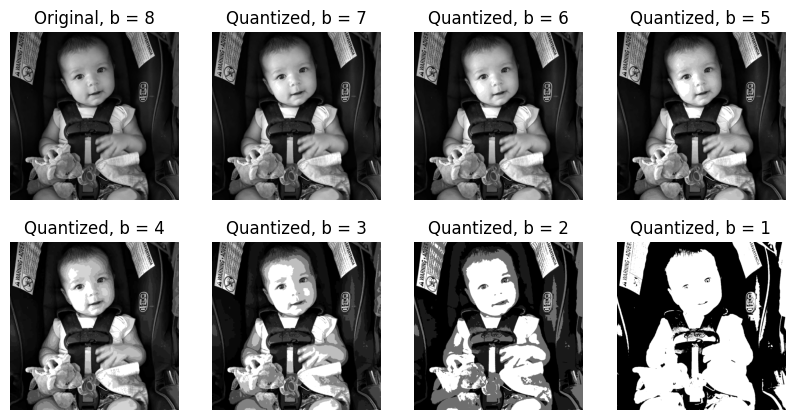

In [27]:
# quntize some test images
plotQuantized(test_img)

#### We now create compressed images using a 7-level Laplacian pyramid with the following three different bits-per-level combinations:

b1 = [1,4,5,7,8,8,8]

b2 = [2,2,2,7,7,8,8]

b3 = [6,5,4,2,1,1,8]

Compression Ratio (b1) = 0.307861328125
Compression Ratio (b2) = 0.346435546875
Compression Ratio (b3) = 0.9422607421875
per pixel error in compression 1 = 0.0022564151056265933
per pixel error in compression 2 = 0.004130734163233368
per pixel error in compression 3 = 0.013190194799252626


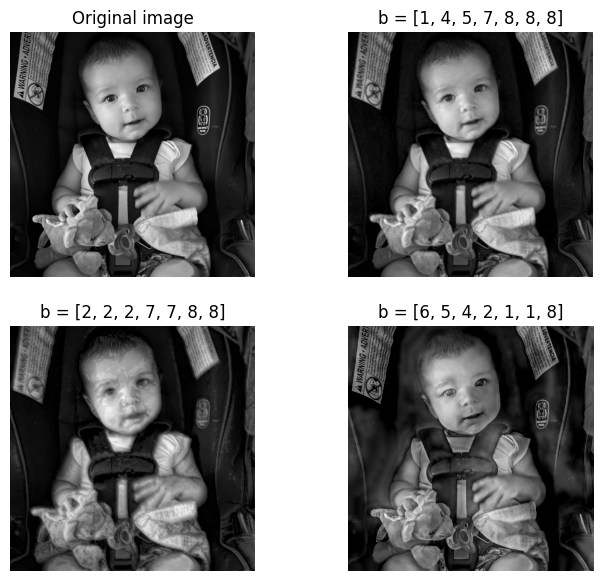

In [28]:
# compress the test image using coarse quantization for the lowest pyramid levels (only 
# L0 level is over compressed, this still preserves image quality)
b1 = [1,4,5,7,8,8,8]
compressed_img1, compression1 = compress(test_img, 7, b1)
print(f"Compression Ratio (b1) = {compression1}")

# compress the test image using coarse quantization for all the lower pyramid levels (multiple 
# lower levels L0,L1,L2 are overcompressed, which makes the image too blurry, because of too 
# much quantizatin error in medium scale features)
b2 = [2,2,2,7,7,8,8]
compressed_img2, compression2 = compress(test_img, 7, b2)
print(f"Compression Ratio (b2) = {compression2}")


# compress the test image using coarse quantization for the higher pyramid levels 
b3 = [6,5,4,2,1,1,8]
compressed_img3, compression3 = compress(test_img, 7, b3)
print(f"Compression Ratio (b3) = {compression3}")


compareCompressed4(test_img, [compressed_img1,compressed_img2,compressed_img3], [b1,b2,b3])

# estimate the error for the two compressed images by taking normalized L2 norm of 
# difference with original image
e1 = np.linalg.norm(test_img-compressed_img1, ord=2) / np.size(test_img)
e2 = np.linalg.norm(test_img-compressed_img2, ord=2) / np.size(test_img)
e3 = np.linalg.norm(test_img-compressed_img3, ord=2) / np.size(test_img)
print(f"per pixel error in compression 1 = {e1}")          
print(f"per pixel error in compression 2 = {e2}")    
print(f"per pixel error in compression 3 = {e3}")    


### 3. Evaluation in the frequency domain

#### In this section, we comupte the fourier transform of the quantization error in compressed images. The error due to quantization is just the difference between the original image and compressed image. The functions below also generate a plot comparing the fourier transforms of the quantizations errors from the different compressed images.

In [29]:
'''
    Function for computing the fourier transform of an image. We use the log of magnitude instead of the original 
    magnitude, to squeeze the values into a smaller range so that they are easier to visualize
        
    Parameters:
    I - 2d image array

    Credits: Some parts of this code were borrowed from the Workshop 3 Notebook
'''
def FFT_image(img):
    # Fourier transform
    f = np.fft.fft2(img)
    # Shift the low frequency component to the center
    f = np.fft.fftshift(f)
    
    # Fourier phase and magnitude
    phase = np.angle(f)
    # the orginal magnitute varies over a very large range of values, so we show log of the value to make it clear
    magnitude_log = np.log(np.abs(f))  

    return (magnitude_log, phase)


'''
    function for making plots of quantization error fourier transforms of compressed images 

    Parameters:
    img - original image
    compressed_img - list of compressed images
    b - list of quantization bits per level
    crop - option for cropping the fourier transform images  
'''
def compareCompressedFFTQuant(img, compressed_img, b, crop=True):

    # compute the fourier transform of the original image
    img_magnitude_log, img_phase = FFT_image(img) 
    
    plt.figure(figsize=(12,11))

    # iterate over each compressed image
    count = 1
    for i in range(3):

        # compute fourier transform of the compressed image   
        compressed_magnitude_log, compressed_phase = FFT_image(compressed_img[i])

        # compute the fourier magnitude and phase of the quantization error (absolute value)
        quantization_error_magnitude = np.abs(compressed_magnitude_log - img_magnitude_log)
        quantization_error_phase = np.abs(compressed_phase - img_phase)

        plt.subplot(3,3,count)
        plt.imshow(compressed_img[i], cmap='gray')
        plt.ylabel('compressed ' + str(i+1))
        plt.axis('off')
        plt.title('b = ' + str(b[i]))
    
        # we crop the fourier transform images to remove the highest frequencies where nothing interesting happens
        if crop:
            lo = 256
            hi = 256+512
            quantization_error_magnitude = quantization_error_magnitude[lo:hi, lo:hi]
            quantization_error_phase = quantization_error_phase[lo:hi, lo:hi]

        # plot the quantization error fourier magnitide    
        plt.subplot(3,3,count+1)
        plt.imshow(quantization_error_magnitude)
        plt.axis('off')
        plt.title("Fourier amplitude")

        # plot the quantization error fourier phase   
        plt.subplot(3,3,count+2)
        plt.imshow(quantization_error_phase)
        plt.axis('off')
        plt.title("Fourier phase")
        count += 3

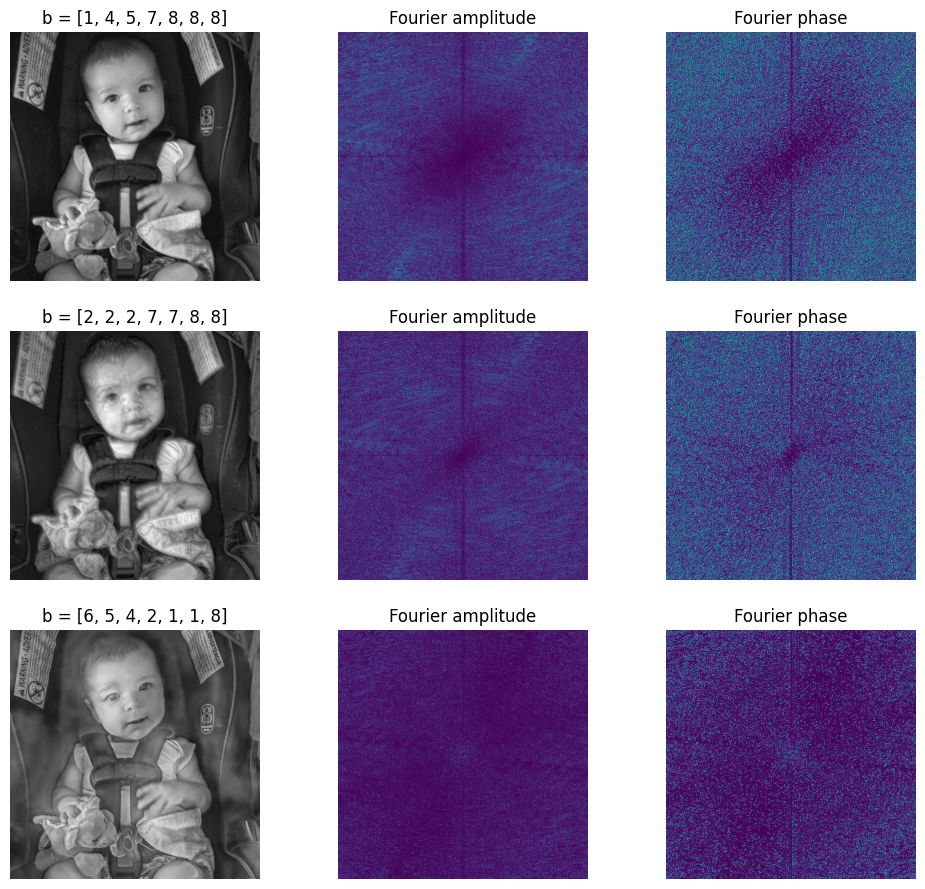

In [30]:
compareCompressedFFTQuant(test_img, [compressed_img1,compressed_img2,compressed_img3], [b1,b2,b3])